In [6]:
import os
import numpy as np
import pandas as pd
import finance as fin
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
"""load S&P500 data"""
dates = pd.date_range('1997-07-17', '2018-01-26')
df = pd.DataFrame(index=dates)
symbol = 'SP500'
df_temp = pd.read_csv(fin.symbol_to_path(symbol), index_col='Date',
                          parse_dates=True, usecols=['Date', 'Adj Close'], 
                          na_values=['nan'])
df_temp = df_temp.rename(columns = {'Adj Close':symbol})
df = df.join(df_temp)
df = df.dropna()
df.tail()
print("df shape:", df.shape)

df shape: (5167, 1)


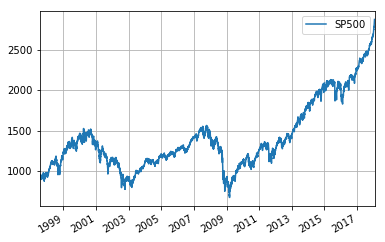

In [11]:
df.plot(kind='line', grid=True)

4915
last element:  0.250879618432
min: -0.48822822743
max: 0.685734412537
mean: 0.062073686792795395
median: 0.0997437153471854
momentum_ds shape: (4915,)


2018-01-22    0.247285
2018-01-23    0.253368
2018-01-24    0.244497
2018-01-25    0.235332
2018-01-26    0.250880
Name: SP500, dtype: float64

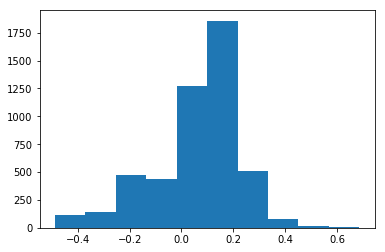

In [41]:
# get the 1 calender year momentum in a data series
n_days = 252 # about 9 months
momentum_ds = fin.momentum_series(df[symbol], n_days)
print (len(momentum_ds))
print ('last element: ' , momentum_ds[-1])
print ('min:' , momentum_ds.min())
print ('max:' , momentum_ds.max())
print ('mean:' , momentum_ds.mean())
print ('median:' , momentum_ds.median())
plt.hist(momentum_ds)
print("momentum_ds shape:", momentum_ds.shape)
momentum_ds.tail()

In [42]:
def get_position_from_threshold( percent_return, long_threshold=-0.05, short_threshold=-0.10): 
    if percent_return > long_threshold:
        return 1.0
    elif percent_return < short_threshold:
        return -1.0
    else:
        return 0.0
    
daily_returns = pd.Series(df['SP500'].pct_change(1)[n_days:], index=momentum_ds.index)
print("daily_returns shape:", daily_returns.shape)
daily_returns.tail()

daily_returns shape: (4915,)


2018-01-22    0.008067
2018-01-23    0.002174
2018-01-24   -0.000560
2018-01-25    0.000603
2018-01-26    0.011841
Name: SP500, dtype: float64

In [55]:
fund_ls = list()
fund_ls.append(df['SP500'][n_days])
for i in range(len(momentum_ds)-1):
    position = get_position_from_threshold(momentum_ds[i])
    fund_value = fund_ls[-1] + (fund_ls[-1] * daily_returns[i+1] * position)
    fund_ls.append(fund_value)
fund_ds = pd.Series(fund_ls, index=daily_returns.index)
print("fund_ds shape:", fund_ds.shape)

fund_ds shape: (4915,)
2808.15195035
2872.870117


fund value: 2808.15195035
index value: 2872.870117


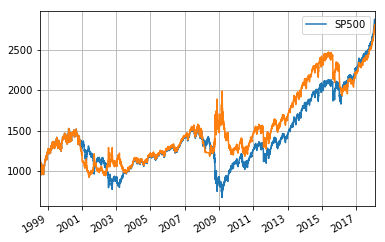

In [56]:
print("fund value:", fund_ds[-1])
print("index value:", df['SP500'][-1])
sp500_graph = df[n_days:].plot(kind='line', label='SP500', grid=True)
fund_graph = fund_ds.plot(kind='line', label='fund', grid=True)
plt.show()

In [ ]:
def get_position_from_threshold( percent_return, long_threshold=-0.05, short_threshold=-0.10): 
    if percent_return > long_threshold:
        return 1.0
    elif percent_return < short_threshold:
        return -1.0
    else:
        return 0
def percent_change(new, old):
    return (new-old)/old

# tune parameters
n_days = 252
long_threshold = -0.02
short_threshold = -0.05
fund_eval_days = 90
stop_loss_threshold = -0.05

n_days_ls = list([20, 50, 90, 150, 252])
long_thresholds_ls = list(np.arange(-0.05, 0.02, 0.01))
short_thresholds_ls = list(np.arange(-0.1, -0.01, 0.01))
fund_eval_days_ls = list([5, 20, 50, 90, 150, 252])
stop_loss_thresholds_ls = list([-0.2, -0.15, -0.1, -0.05])

total_epochs = len(n_days_ls)*len(long_thresholds_ls)*len(short_thresholds_ls)*len(fund_eval_days_ls)*len(stop_loss_thresholds_ls)
print("total epochs:", total_epochs)

best_nd = 0
best_lt = 0
best_st = 0
best_fed = 0
best_slt = 0
max_value = 0
epoch = 0

for n_days in n_days_ls:
    momentum_ds = fin.momentum_series(df[symbol], n_days)
    daily_returns = pd.Series(df['SP500'].pct_change(1)[n_days:], index=momentum_ds.index)
    for long_threshold in long_thresholds_ls:
        for short_threshold in short_thresholds_ls:
            for fund_eval_days in fund_eval_days_ls:
                for stop_loss_threshold in stop_loss_thresholds_ls:
                    epoch += 1
                    if (epoch % 200 == 0 or epoch == total_epochs):
                        print("{0:.1f}%".format(epoch/total_epochs*100))
                        
                    fund_ls = list()
                    fund_ls.append(df['SP500'][n_days])
                    for i in range(len(momentum_ds)-1):
                        position = get_position_from_threshold(momentum_ds[i], long_threshold=long_threshold, short_threshold=short_threshold)

                        # look back and evaluate how the fund is performing over the past few days
                        if (len(fund_ls) >= fund_eval_days):
                            # overwrite position to 0 (do nothing) if loss in the last few days exceeds threshold
                            if percent_change(fund_ls[-1], fund_ls[-fund_eval_days]) < stop_loss_threshold:
                                position = 0 

                        fund_value = fund_ls[-1] + (fund_ls[-1] * daily_returns[i+1] * position)
                        fund_ls.append(fund_value)

                    if max_value < fund_ls[-1]:
                        max_value = fund_ls[-1]
                        best_nd = n_days
                        best_lt = long_threshold
                        best_st = short_threshold
                        best_fed = fund_eval_days
                        best_slt = stop_loss_threshold

print("best n_days:", best_nd)
print("best long threshold:", best_lt)
print("best short threshold:", best_st)
print("best fund eval days:", best_fed)
print("best stop loss threshold:", best_slt)
    
'''    
fund_ds = pd.Series(fund_ls, index=daily_returns.index)
print("fund value:", fund_ds[-1])
print("index value:", df['SP500'][-1])
sp500_graph = df[n_days:].plot(kind='line', label='SP500', grid=True)
fund_graph = fund_ds.plot(kind='line', label='fund', grid=True)
plt.show()
'''

total epochs: 8640
2.3%
4.6%
6.9%
9.3%
11.6%


In [129]:
max_value

1.6487048639553135e+308

fund value: 2295.20006104
index value: 2872.870117


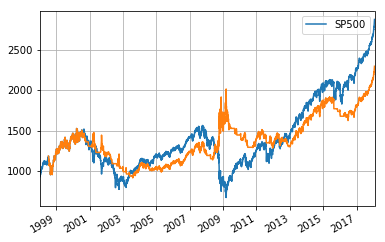

In [130]:
n_days = best_nd
long_threshold = best_lt
short_threshold = best_st
fund_eval_days = best_fed
stop_loss_threshold = best_slt

momentum_ds = fin.momentum_series(df[symbol], n_days)
daily_returns = pd.Series(df['SP500'].pct_change(1)[n_days:], index=momentum_ds.index)
fund_ls = list()
fund_ls.append(df['SP500'][n_days])
    
for i in range(len(momentum_ds)-1):
    position = get_position_from_threshold(momentum_ds[i], long_threshold=long_threshold, short_threshold=short_threshold)

    # look back and evaluate how the fund is performing over the past few days
    if (len(fund_ls) >= fund_eval_days):
        # overwrite position to 0 (do nothing) if loss in the last few days exceeds threshold
        if percent_change(fund_ls[-1], fund_ls[-fund_eval_days]) < stop_loss_threshold:
            position = 0 

    fund_value = fund_ls[-1] + (fund_ls[-1] * daily_returns[i+1] * position)
    fund_ls.append(fund_value)
    
print("fund value:", fund_ds[-1])
print("index value:", df['SP500'][-1])
sp500_graph = df[n_days:].plot(kind='line', label='SP500', grid=True)
fund_graph = fund_ds.plot(kind='line', label='fund', grid=True)
plt.show()